# We shall see in this notebook the conception, training and testing of a neural network model which can spot normal lungs from lung with pneumonia.
This model achieved +90% accuracy and will 100% spot a Pneumonia in our current datasets.

In [1]:

import datetime
import os
import os.path
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from skimage.transform import resize
from skimage import exposure
from skimage.filters import rank
from skimage.morphology import disk
from sklearn.model_selection import StratifiedKFold

We import tensor flow and different package which will be use later on.

In [2]:
validation_split = 0.2
img_height = 180
img_width = 180
batch_size = 32

We set up some variable for the next step.

In [3]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/chest_Xray/train",
    labels="inferred",
    color_mode="grayscale",
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/chest_Xray/test",
    labels="inferred",
    label_mode='binary',
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
)

Found 5190 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


Since our datasets are in directories in the form of chest_Xray/(train|tes|val)/(NORMAL/PNEUMONIA) we use the keras function preprocessing image_dataset_from_directory which will create a tensorflow dataset object. We set some option for its creation:
- labels="inferred" -> the labels of the images are set with the folder name they are contained in NORMAL or PNEUMONIA
- label_mode='binary'-> Since we only have two labels : NORMAL or PNEUMONIA we chose a binary label mode which will convert our labels to true or false
- batch_size=batch_size -> the size of each batch when we will be training and evaluating our models
- image_size=(img_height, img_width) -> resize of the images in our datasets 
- shuffle=True -> shuffle the image in our dataset for better validation split

In [4]:
def count_files(dir):
    return len([1 for x in list(os.scandir(dir)) if x.is_file()])


COUNT_NORMAL = count_files("datasets/chest_Xray/train/NORMAL")
COUNT_PNEUMONIA = count_files("datasets/chest_Xray/train/PNEUMONIA")
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
weight_for_0 = (1 / COUNT_NORMAL) * TRAIN_IMG_COUNT / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * TRAIN_IMG_COUNT / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
# class_weight = {0: 1, 1: 1}

We have way more PNEUMONIA image than NORMAL which could cause a bias in our training. We adjust the weight of our outputs for better result.

In [5]:
def contrast_stretch(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    if (p2 == p98):
        return img  # some images are just one color, so they gerenate an divide by zero error, so return original image
    img_contrast_stretch = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_contrast_stretch


def equalization(img,y):
    # some images are just one color, so they gerenate a divide by zero error
    #     so return original image if the min and max values are the same
    if (np.max(img) == np.min(img)):
        return img
        # Equalization
    img_equalized = exposure.equalize_hist(img)
    return img_equalized, y


def adaptive_equalization(img):
    # some images are just one color, so they gerenate a divide by zero error
    #     so return original image if the min and max values are the same
    if (np.max(img) == np.min(img)):
        return img
        # Adaptive Equalization
    img_adaptive_equalized = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adaptive_equalized


def local_equalization(img):
    # some images are just one color, so they gerenate a divide by zero error
    #     so return original image if the min and max values are the same
    if (np.max(img) == np.min(img)):
        return img
        # Local Equalization--for details see http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html
    selem = disk(30)
    img_local_equal = rank.equalize(img, selem=selem)
    return img_local_equal


def augment(x, y):
    #image = tf.image.random_flip_left_right(x)
    #image = tf.image.random_brightness(x, max_delta=0.8)
    image = tf.image.random_contrast(x, 0.5, 0.8)
    # image = contrast_stretch(image)
    # image = local_equalization(image)
    # image = adaptive_equalization(image)
    #image = equalization(image)
    return image, y


ds_train = ds_train.map(augment)

To have better result we need to augment our dataset with some image modification. We can comment the augmentation to disable it or change the parameters in the augment function.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

We setup a cache to have better performance in our training and test.

In [7]:
def build_model():
    inputs = keras.Input(shape=(img_height, img_width, 1))
    x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = layers.SeparableConv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.SeparableConv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.SeparableConv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.SeparableConv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.7)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = build_model()

We create our model using five time: Convolution Filter -> Convolution Filter -> Batchnormalization -> Max Pooling -> Dropout (optional)
Batchnormalization and dropout are there to avoid the overfitting of our model to the dataset.

We then Flatten the output of the Convolution networks and add three Dense layers with batchnormalization layers and dropout layers.

Our last output layer is a Dense layer of one unit since we set the labels mode to binary with and sigmoid activation which fit the binary output. 



In [8]:
ds_train = ds_train.shuffle(TRAIN_IMG_COUNT)
ds_train_size = len(ds_train)
tmp_ds_train = ds_train
split_nb = ds_train_size * (1 - validation_split)
ds_train = ds_train.take(np.int64(split_nb))
ds_val = tmp_ds_train.skip(np.int64(split_nb))

We now need to set our validation split from our training set.

We shuffle the dataset again and then keep the 80% percent of our dataset as traing dataset and the rest as our validation dataset

In [9]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
]

We setup the metrics we will use to evaluate our model. Binary Accuracy and the AUC metrics are our most important parameter.

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

We create the different callbacks for the training:
- a checkpoint to save our model which performed the best based on its result on the validation set

- an early stoping to stop our model traing when he begin to overfitt.

- A callback for tensorboard to save the training and validation logs

In [11]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=METRICS,
)

We set a learning rate for our optimizer to have better result and avoid the plateau.

We then compile our model using Adam as our optimizer feeding it the learning rate schedule. We base the loss of our model with binary_crossentropy sinc our labels are in binary modes and we add the metrics defined erlier to our compilation. 

In [12]:
model.fit(ds_train, validation_data=ds_val, epochs=100, class_weight=class_weight, verbose=1,
          callbacks=[tensorboard_callback, checkpoint, early_stopping])

Epoch 1/100
130/130 [==============================] - 114s 340ms/step - loss: 0.6918 - binary_accuracy: 0.6547 - precision: 0.8520 - recall: 0.6377 - auc: 0.7230 - val_loss: 1.0022 - val_binary_accuracy: 0.7206 - val_precision: 0.7518 - val_recall: 0.9326 - val_auc: 0.4993
Epoch 2/100
130/130 [==============================] - 35s 271ms/step - loss: 0.2891 - binary_accuracy: 0.8763 - precision: 0.9573 - recall: 0.8693 - auc: 0.9498 - val_loss: 94.3720 - val_binary_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/100
130/130 [==============================] - 35s 271ms/step - loss: 0.3067 - binary_accuracy: 0.8781 - precision: 0.9505 - recall: 0.8805 - auc: 0.9451 - val_loss: 0.1996 - val_binary_accuracy: 0.9398 - val_precision: 0.9768 - val_recall: 0.9409 - val_auc: 0.9820
Epoch 4/100
130/130 [==============================] - 35s 269ms/step - loss: 0.2158 - binary_accuracy: 0.9173 - precision: 0.9736 - recall: 0.9127 - auc: 0.9705 - val_loss: 0.

Epoch 31/100
130/130 [==============================] - 34s 260ms/step - loss: 0.1397 - binary_accuracy: 0.9475 - precision: 0.9828 - recall: 0.9458 - auc: 0.9868 - val_loss: 0.3581 - val_binary_accuracy: 0.8942 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.9851
Epoch 32/100
130/130 [==============================] - 34s 258ms/step - loss: 0.1132 - binary_accuracy: 0.9606 - precision: 0.9888 - recall: 0.9585 - auc: 0.9906 - val_loss: 0.2510 - val_binary_accuracy: 0.8968 - val_precision: 1.0000 - val_recall: 0.8599 - val_auc: 0.9950
Epoch 33/100
130/130 [==============================] - 34s 260ms/step - loss: 0.1204 - binary_accuracy: 0.9423 - precision: 0.9912 - recall: 0.9300 - auc: 0.9891 - val_loss: 0.0976 - val_binary_accuracy: 0.9545 - val_precision: 0.9959 - val_recall: 0.9420 - val_auc: 0.9968
Epoch 34/100
130/130 [==============================] - 34s 259ms/step - loss: 0.0990 - binary_accuracy: 0.9615 - precision: 0.9922 - recall: 0.9544 - auc: 0.9927 - val_loss: 

We then train our model. Using our train/validation split, for 100 epoch since we have an early stopping anyway.

In [13]:
model.load_weights("best_model.h5")
model.evaluate(ds_test)

20/20 [==============================] - 6s 192ms/step - loss: 1.0272 - binary_accuracy: 0.8045 - precision: 0.7680 - recall: 0.9846 - auc: 0.8677


[1.0271610021591187,
 0.8044871687889099,
 0.7680000066757202,
 0.9846153855323792,
 0.8677459955215454]

We load the model which performed the best and evalute it using out test dataset.

In [14]:
def get_random_xray():
    PATH = ["datasets/chest_Xray/test/NORMAL", "datasets/chest_Xray/test/PNEUMONIA"]
    rand = random.randint(0, 1)
    rand_file = random.choice(os.listdir(PATH[rand]))
    if rand == 0:
        rand_file = "datasets/chest_Xray/test/NORMAL/" + rand_file
        print("this XRay is from a Normal lung")
    else:
        rand_file = "datasets/chest_Xray/test/PNEUMONIA/" + rand_file
        print("this XRay is from a Pneumonia lung")
    return rand_file


for i in range(10):
    file_name = get_random_xray()
    img = keras.preprocessing.image.load_img(
        file_name, target_size=(img_width, img_height), color_mode='grayscale'
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    print(
        "This image is %.2f percent Normal and %.2f percent Pneumonia."
        % (100 * (1 - score), 100 * score)
    )

this XRay is from a Pneumonia lung
This image is 0.00 percent Normal and 100.00 percent Pneumonia.
this XRay is from a Normal lung
This image is 99.85 percent Normal and 0.15 percent Pneumonia.
this XRay is from a Normal lung
This image is 71.44 percent Normal and 28.56 percent Pneumonia.
this XRay is from a Pneumonia lung
This image is 0.00 percent Normal and 100.00 percent Pneumonia.
this XRay is from a Pneumonia lung
This image is 0.01 percent Normal and 99.99 percent Pneumonia.
this XRay is from a Pneumonia lung
This image is 0.00 percent Normal and 100.00 percent Pneumonia.
this XRay is from a Pneumonia lung
This image is 0.00 percent Normal and 100.00 percent Pneumonia.
this XRay is from a Pneumonia lung
This image is 0.00 percent Normal and 100.00 percent Pneumonia.
this XRay is from a Normal lung
This image is 72.39 percent Normal and 27.61 percent Pneumonia.
this XRay is from a Normal lung
This image is 46.76 percent Normal and 53.24 percent Pneumonia.


We created a simple fonction which pick 10 random images from the test dataset and test our model with those images, diplaying our images scores of Pneumonia or Normal.

As we can see in the result the model will always spot a pneumonia but will sometimes tag Normal lungs as Pneumonia. That is why the AUC metrics is hight and the binaary accuracy is lower

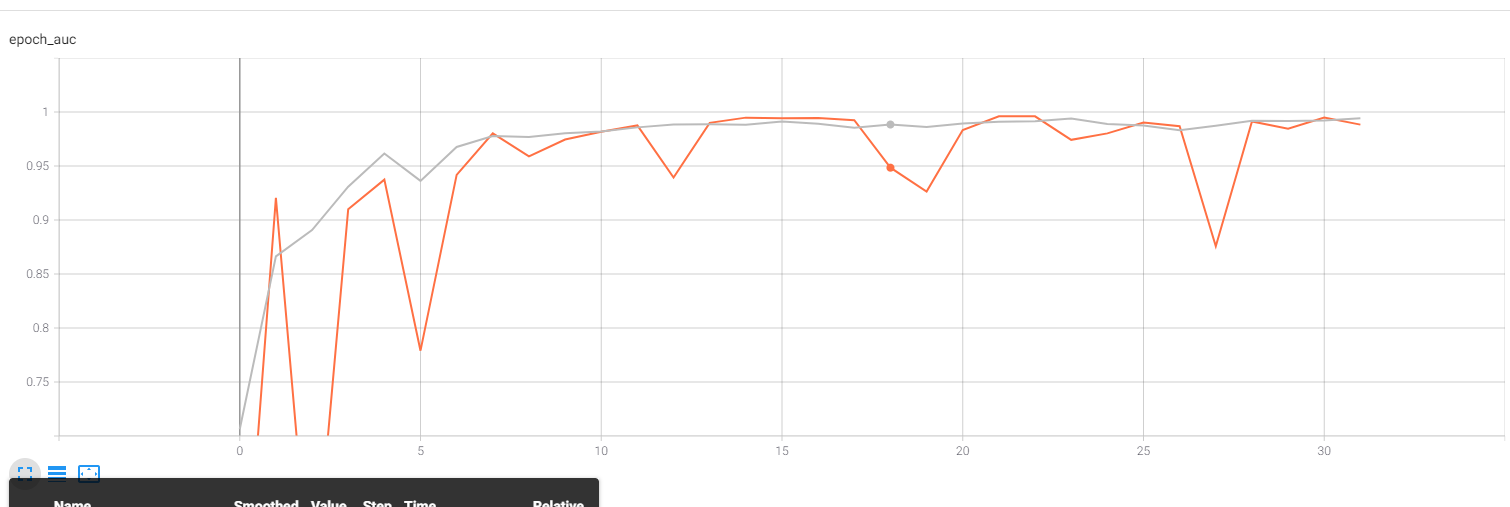

As we can see in this graphic referencing the AUC by epoch (grey is the result on the training set and orange is on the validation set) the auc on the validation set is next to 99% on some epoch.

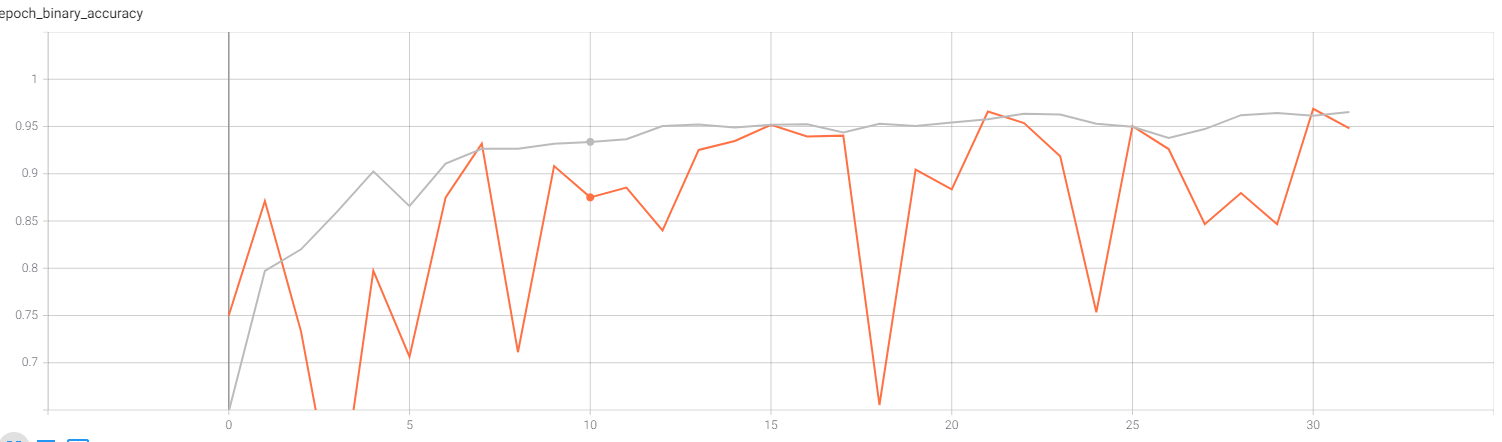

The binary accuracy fluctuate more but still as good result on the latest epoch.